In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'aiim-emotion-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77823%2F8553100%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240529%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240529T111024Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7d64b51623dc44a5088e211860a2586cb5f4f65c4e268c21086797429908df19f4992ad676969a26719c005a2eb8a8876b719c0f1a7573663d9a9e07444cf1edc1c02a11f823e63ce8e17ae95d7e79305fe4c7f8e6efffdd3c4b65870a484c912b593549d83809ecde36f508e440796a311c81b30e2ddee0a842e2e1d1470db287f9050997a7addd702827308275d89b8bfdc6553c36f03dad48df92d95a621f3b52c96c9e69f34e7cab92a4bd1433d83251e7e651be7b88a0c4dc3db9d3c4cfe3aa6c2a341fdc340dd311142039410ca561656b3dcd760319a6783749f0d679709553ee7de36c3484da3cb4e24e792330366099ed7d2b4f1a810c44f39156ba'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 18175099 bytes downloaded
Downloaded and uncompressed: aiim-emotion-classification
Data source import complete.


In [2]:
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import f1_score

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
base_directory = '/kaggle/input/aiim-emotion-classification/aiim-emotion-classification/'
batch_size = 32
epochs = 20

In [4]:
# Documentation: https://keras.io/api/data_loading/image/
train_ds, validation_ds = image_dataset_from_directory(
    directory=base_directory + 'train/',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=420,
    subset="both",
    validation_split=0.1,
    image_size=(100, 100))


class_names = train_ds.class_names

print(train_ds)

Found 9108 files belonging to 5 classes.
Using 8198 files for training.
Using 910 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


## Normalization

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    RandomRotation(0.15),
    RandomZoom(0.1),
    RandomContrast(0.2),
    RandomBrightness(0.2)
])

# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Convolutional Operation

## Convolutional Layer 1
* Number of input Channels: 1 (Greyscale)
* Number of output Channels: 32
* Kernel size: 3x3
* Stride: 1
* Padding: 1

## Max Pooling Layer 1
* Kernel size: 2x2
* Stride: 2
* Padding: 0

## Convolutional Layer 2
* Number of input Channels: 32
* Number of output Channels: 64
* kernel size: 3 (3x3 kernel)
* Stride: 1
* Padding 1

## Max Pooling Layer 2
* Kernel size: 2x2
* Stride: 2
* Padding: 0

## Flatten Layer
Converts the multi-dimensional output of the Convolutional and Pooling layers into a 1D vector.

## Fully Connected Layer 1
* Input features: 64 * 25 * 25 (output size after the second pooling layer, flattened)
* Output features: 128

## Fully Connected Layer 2
* Input features: 128
* Output features: Number of classes (5 different emotions)

In [6]:
model = Sequential()

# Normalization
model.add(normalization_layer)

# Convolutional Layer 1
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(100,100,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Convolutional Layer 2
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Convolutional Layer 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


Try Learning rate of 0.001

In [7]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001)


# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=SGD(learning_rate=0.01, momentum=0.9),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')



# Training des Modells
history = model.fit(train_ds, validation_data=validation_ds, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr, model_checkpoint])


Epoch 1/20
257/257 [==============================] - 20s 42ms/step - loss: 8.6924 - accuracy: 0.2205 - val_loss: 5.2388 - val_accuracy: 0.2352 - lr: 0.0100
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


257/257 [==============================] - 10s 38ms/step - loss: 3.8591 - accuracy: 0.2152 - val_loss: 2.8677 - val_accuracy: 0.2264 - lr: 0.0100
Epoch 3/20
257/257 [==============================] - 10s 38ms/step - loss: 2.3893 - accuracy: 0.2142 - val_loss: 2.0405 - val_accuracy: 0.2187 - lr: 0.0100
Epoch 4/20
257/257 [==============================] - 8s 33ms/step - loss: 1.8728 - accuracy: 0.2109 - val_loss: 1.7472 - val_accuracy: 0.2187 - lr: 0.0100
Epoch 5/20
257/257 [==============================] - 10s 38ms/step - loss: 1.6883 - accuracy: 0.2111 - val_loss: 1.6434 - val_accuracy: 0.2187 - lr: 0.0100
Epoch 6/20
257/257 [==============================] - 10s 39ms/step - loss: 1.6253 - accuracy: 0.2175 - val_loss: 1.6176 - val_accuracy: 0.2187 - lr: 0.0100
Epoch 7/20
257/257 [==============================] - 9s 34ms/step - loss: 1.6141 - accuracy: 0.2146 - val_loss: 1.6016 - val_accuracy: 0.2187 - lr: 0.0100
Epoch 8/20
257/257 [==============================] - 9s 36ms/step - lo

In [8]:
# Vorhersagen für die Validierungsdaten
y_val_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_val_pred = model.predict(validation_ds)

# Umwandeln der Vorhersagen in One-Hot-Format
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_true, axis=1)

# F1-Score berechnen
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print("F1-Score: ", f1)

29/29 [==============================] - 0s 6ms/step
F1-Score:  0.07848076179906657


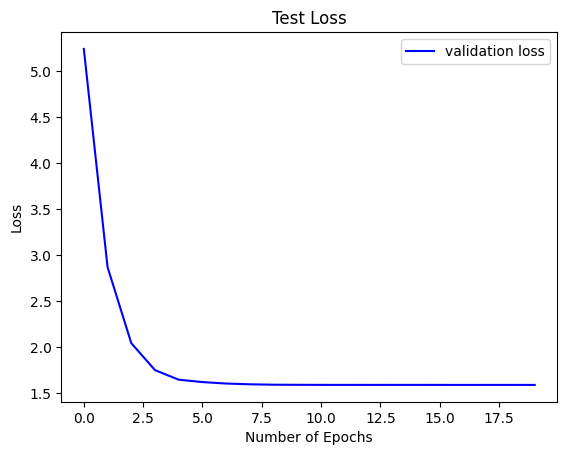

In [9]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Create Submission

In [10]:
test_ds = image_dataset_from_directory(
    directory=base_directory + 'test/',
    labels=None,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32,
    shuffle=True,
    seed=69,
    image_size=(100, 100))

# Bilddateinamen extrahieren
file_paths = test_ds.file_paths
file_names = [file_path.split('/')[-1] for file_path in file_paths]

# test_ds = test_ds.map(lambda x: (normalization_layer(x)))


y_test = model.predict(test_ds)


y_pred_indices = np.argmax(y_test, axis=1)

# Numerische Labels in Kategorienamen umwandeln
y_pred_labels = [class_names[idx] for idx in y_pred_indices]

# DataFrame erstellen
df = pd.DataFrame({
    'Id': file_names,
    'emotions': y_pred_labels
})

# DataFrame als CSV speichern
df.to_csv('/submission.csv', index=False)

Found 2388 files belonging to 1 classes.
75/75 [==============================] - 1s 8ms/step
